# Section 3: Sentiment and Emotion


# 3.1	Sentiment analysis with BERT.


# Imported Required Libraries 

In [41]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW, AutoTokenizer, BertForSequenceClassification, get_scheduler, DataCollatorWithPadding, set_seed
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns
import spacy 
import random


# Seed for reproducibility
SEED = 40457510
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
set_seed(SEED)
# Disabling parallelism warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Loading spaCy model for sentence segmentation/ For last sentence splitting
nlp = spacy.load("en_core_web_sm")


# Loading and Processing Data(Extracting last sentence of each story)

In [43]:
import json

# Loading the dataset
file_path = "stories.json" 
with open(file_path, "r", encoding="utf-8") as file:
    data = json.load(file)

# Extracting last sentence and outcome from each story
story_sentiment = []
for story in data["stories"]:
    doc = nlp(story["story"])  # Process text with spaCy
    sentences = [sent.text for sent in doc.sents]
    
# Extracting last sentence (will skip stories with no sentences)
    if len(sentences) > 0:
        last_sentence = sentences[-1]  # Get last sentence
        outcome_label = 1 if story["outcome"] == "victory" else 0  # Binary label

        story_sentiment.append({
            "index": story["index"],
            "last_sentence": last_sentence,
            "outcome": outcome_label
        })

# Converting to DataFrame 
df = pd.DataFrame(story_sentiment)

# Printing dataset summary
print(df.head())
print(f"Total stories processed: {len(df)}")


   index                                      last_sentence  outcome
0      0  His final gambit, a symphony of silence permea...        0
1      1  The illustrious career of our protagonist met ...        0
2      2  The townsfolk slept, oblivious to the unfoldin...        1
3      3  This once-simple farmer had transformed into t...        1
4      4  His relentless pursuit of righting the wrong h...        1
Total stories processed: 602


# Train-Test Split

In [47]:
#train_texts, test_texts, y_train, y_test = train_test_split(
 #   df["last_sentence"].tolist(), df["outcome"].tolist(), 
 #   test_size=0.2, random_state=40457510, stratify=df["outcome"]
#)



# Splitting dataset
train_texts, test_texts, y_train, y_test = train_test_split(
    df["last_sentence"].tolist(), df["outcome"].tolist(),
    test_size=0.2, random_state=SEED, stratify=df["outcome"]
)
train_texts, val_texts, y_train, y_val = train_test_split(
    train_texts, y_train, test_size=0.2, random_state=SEED, stratify=y_train
)

# Printing dataset sizes
print(f"Training samples: {len(train_texts)},Validation samples: {len(val_texts)}, Testing samples: {len(test_texts)}")

Training samples: 384,Validation samples: 97, Testing samples: 121


# Tokenizor and Model

In [49]:

CHECKPOINT = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT)

MAX_LEN = 128  # Last sentences are short, so 128 tokens should be enough

# Tokenizing datasets
train_encodings = tokenizer(train_texts, padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="pt")
val_encodings = tokenizer(val_texts, padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="pt")                          
test_encodings = tokenizer(test_texts, padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="pt")


# Converting labels to tensors
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)
test_labels = torch.tensor(y_test)

# Use DataCollator for Padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


# Creating PyTorch Dataset 

In [51]:
class OutcomeDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

# Creating Dataset Objects
train_dataset = OutcomeDataset(train_encodings, train_labels)
val_dataset   = OutcomeDataset(val_encodings, val_labels)
test_dataset = OutcomeDataset(test_encodings, test_labels)


In [11]:
test_dataset

In [13]:
train_dataset

# Checking whether dataset is balance between 'victory' and 'defeat'

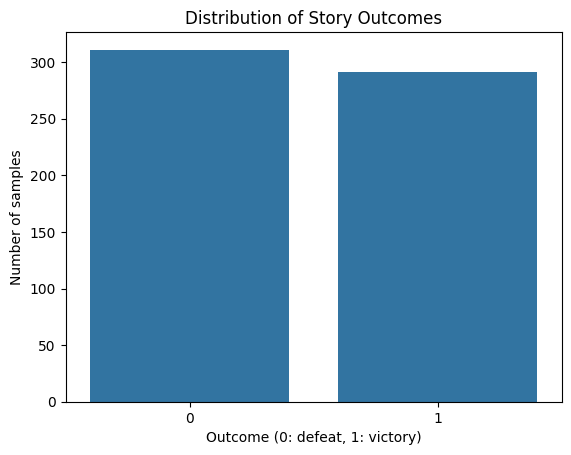

602


In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='outcome', data=df)
plt.xlabel("Outcome (0: defeat, 1: victory)")
plt.ylabel("Number of samples")
plt.title("Distribution of Story Outcomes")
plt.show()
print(len(df))

# Loading Model, Define Optimizer & Scheduler

In [55]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Loading pre-trained BERT model for binary classification
model = BertForSequenceClassification.from_pretrained(CHECKPOINT, num_labels=2).to(device)

# Optimizer & Scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

EPOCHS = 5
BATCH_SIZE = 4


num_trainin g_steps = (len(train_dataset) // BATCH_SIZE) * EPOCHS
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)


Using device: mps


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/hinaghazanfar/Documents/anaconda3/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Creating DataLoaders

In [57]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=data_collator)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator)

In [21]:
train_loader

# Fine-Tune BERT for Sentiment Analysis EPOCHS = 5, BATCH_SIZE = 4


Training Progress: 100%|█████████████████████████| 5/5 [32:35<00:00, 391.18s/it]

Training Progress:  20%|█████▏                    | 1/5 [00:24<01:38, 24.63s/it]

Epoch 1: Train Loss=0.6276, Train Acc=0.6432, Val Loss=0.4769, Val Acc=0.8367



Training Progress:  40%|██████████▍               | 2/5 [00:48<01:12, 24.30s/it]

Epoch 2: Train Loss=0.2804, Train Acc=0.8724, Val Loss=0.4172, Val Acc=0.8163



Training Progress:  60%|███████████████▌          | 3/5 [01:12<00:48, 24.25s/it]

Epoch 3: Train Loss=0.0816, Train Acc=0.9740, Val Loss=0.6260, Val Acc=0.7959



Training Progress:  80%|████████████████████▊     | 4/5 [01:37<00:24, 24.20s/it]

Epoch 4: Train Loss=0.0462, Train Acc=0.9818, Val Loss=0.9042, Val Acc=0.7551



Training Progress: 100%|██████████████████████████| 5/5 [02:01<00:00, 24.36s/it]

Epoch 5: Train Loss=0.0335, Train Acc=0.9948, Val Loss=0.7209, Val Acc=0.8163


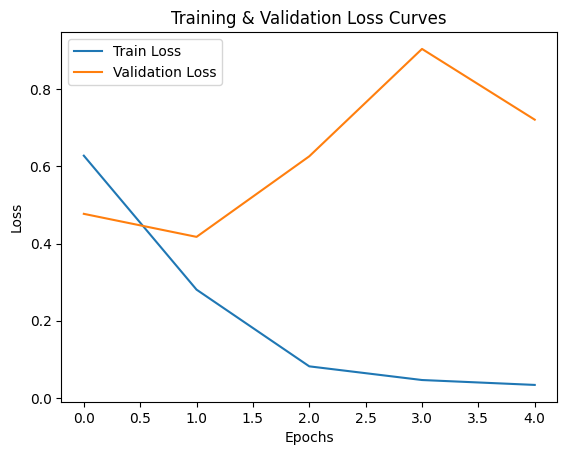

In [59]:
# Training loop
train_losses, val_losses, train_accs, val_accs = [], [], [], []

progress_bar = tqdm(range(EPOCHS), desc="Training Progress", leave=True, dynamic_ncols=True)
for epoch in range(EPOCHS):
    model.train()
    total_train_loss, correct_train = 0, 0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
        preds = torch.argmax(outputs.logits, dim=1)
        correct_train += (preds == batch["labels"]).sum().item()
    
    train_loss = total_train_loss / len(train_loader)
    train_acc = correct_train / len(train_dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    total_val_loss, correct_val = 0, 0
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_val_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            correct_val += (preds == batch["labels"]).sum().item()
    
    val_loss = total_val_loss / len(val_loader)
    val_acc = correct_val / len(val_dataset)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")
    progress_bar.update()
# Plotting Loss Curves
plt.figure()
plt.plot(range(EPOCHS), train_losses, label="Train Loss")
plt.plot(range(EPOCHS), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss Curves")
plt.show()

# Evaluating the Model 


Model Accuracy of BERT Modedl For Sentiment Analysis: 0.7934

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.81      0.80        63
           1       0.79      0.78      0.78        58

    accuracy                           0.79       121
   macro avg       0.79      0.79      0.79       121
weighted avg       0.79      0.79      0.79       121



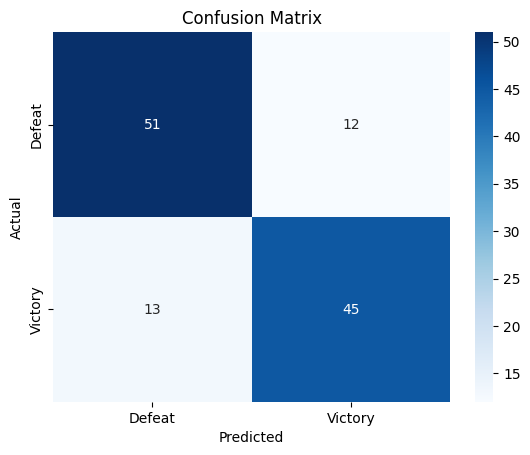

In [61]:
# Evaluation on Test Set
model.eval()
test_preds, test_true = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        test_preds.extend(predictions)
        test_true.extend(batch["labels"].cpu().numpy())

# Test Accuracy
accuracy = accuracy_score(test_true, test_preds)
print(f"\nModel Accuracy of BERT Modedl For Sentiment Analysis: {accuracy:.4f}")

# Classification Report
print("\nClassification Report:\n", classification_report(test_true, test_preds))

# Confusion Matrix
cm = confusion_matrix(test_true, test_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Defeat", "Victory"], yticklabels=["Defeat", "Victory"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# Modify Classifier Head (Prevent Overfitting)- increasing dropout=0.5

In [70]:
df.head()

,index,last_sentence,outcome
0,0,"His final gambit, a symphony of silence permea...",0
1,1,The illustrious career of our protagonist met ...,0
2,2,"The townsfolk slept, oblivious to the unfoldin...",1
3,3,This once-simple farmer had transformed into t...,1
4,4,His relentless pursuit of righting the wrong h...,1


In [72]:
train_dataset

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   index                                      last_sentence  outcome
0      0  His final gambit, a symphony of silence permea...        0
1      1  The illustrious career of our protagonist met ...        0
2      2  The townsfolk slept, oblivious to the unfoldin...        1
3      3  This once-simple farmer had transformed into t...        1
4      4  His relentless pursuit of righting the wrong h...        1
Total stories processed: 602
Training samples: 384, Validation samples: 97, Testing samples: 121
Using device: mps


/Users/hinaghazanfar/Documents/anaconda3/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Progress:  20%|█████▏                    | 1/5 [00:30<02:00, 30.13s/it]

Epoch 1: Train Loss=0.3528, Train Acc=0.4818, Val Loss=0.6789, Val Acc=0.6939


Training Progress:  40%|██████████▍               | 2/5 [00:59<01:29, 29.74s/it]

Epoch 2: Train Loss=0.3477, Train Acc=0.5208, Val Loss=0.6174, Val Acc=0.7959


Training Progress:  60%|███████████████▌          | 3/5 [01:29<00:59, 29.68s/it]

Epoch 3: Train Loss=0.2870, Train Acc=0.7474, Val Loss=0.4648, Val Acc=0.7551


Training Progress:  80%|████████████████████▊     | 4/5 [01:58<00:29, 29.59s/it]

Epoch 4: Train Loss=0.1837, Train Acc=0.8646, Val Loss=0.4417, Val Acc=0.7755


Training Progress: 100%|██████████████████████████| 5/5 [02:28<00:00, 29.55s/it]

Epoch 5: Train Loss=0.1101, Train Acc=0.9297, Val Loss=0.3904, Val Acc=0.8367


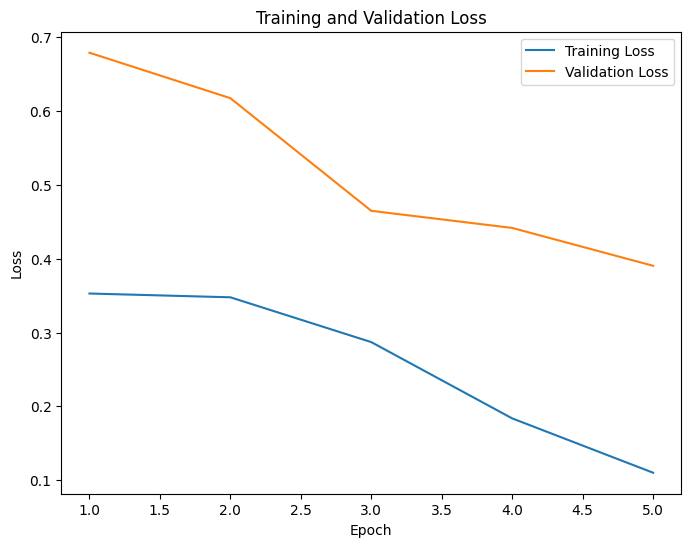


 Test Accuracy: 0.8760

 Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.86      0.88        63
           1       0.85      0.90      0.87        58

    accuracy                           0.88       121
   macro avg       0.88      0.88      0.88       121
weighted avg       0.88      0.88      0.88       121



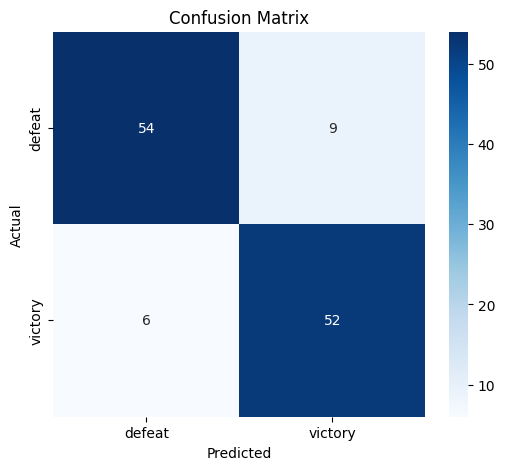

In [153]:
import torch.nn as nn

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
set_seed(SEED)

# Print dataset summary
print(df.head())
print(f"Total stories processed: {len(df)}")

# Print dataset sizes
print(f"Training samples: {len(train_texts)}, Validation samples: {len(val_texts)}, Testing samples: {len(test_texts)}")


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")


from transformers import BertConfig

# Load model configuration with new dropout rate

config = BertConfig.from_pretrained(CHECKPOINT, num_labels=2, hidden_dropout_prob=0.3)
# Reinitialize the model with new dropout settings
model_Hina_senti = BertForSequenceClassification.from_pretrained(CHECKPOINT, config=config).to(device)


# Optimizer & Scheduler
optimizer = AdamW(model_Hina_senti.parameters(), lr=1e-5, weight_decay=0.02)
EPOCHS = 5
BATCH_SIZE = 2

ACCUMULATION_STEPS = 2

#num_warmup_steps = int(0.05 * num_training_steps) # 5% warm-up
num_training_steps = (len(train_dataset) // BATCH_SIZE) * EPOCHS
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=data_collator)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator)



# Fine-Tune BERT for Sentiment Analysis with Validation, Training Accuracy & Early Stopping ---
torch.mps.empty_cache()
#progress_bar = tqdm(range(EPOCHS * len(train_loader)))
progress_bar = tqdm(range(EPOCHS), desc="Training Progress", leave=True, dynamic_ncols=True)
train_losses = []
val_losses = []
train_accuracies = []

# Early stopping variables
best_val_loss = float('inf')
patience = 2
patience_counter = 0

      

for epoch in range(EPOCHS):
    model_Hina_senti.train()
    total_train_loss, correct_train = 0, 0
    optimizer.zero_grad()
    for i, batch in enumerate(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model_Hina_senti(**batch)
        loss = outputs.loss / ACCUMULATION_STEPS
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        if (i + 1) % ACCUMULATION_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad()
    
        preds = torch.argmax(outputs.logits, dim=1)
        correct_train += (preds == batch["labels"]).sum().item()
    
    train_loss = total_train_loss / len(train_loader)
    train_acc = correct_train / len(train_dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model_Hina_senti.eval()
    total_val_loss, correct_val = 0, 0
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model_Hina_senti(**batch)
            loss = outputs.loss
            total_val_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            correct_val += (preds == batch["labels"]).sum().item()
    
    val_loss = total_val_loss / len(val_loader)
    val_acc = correct_val / len(val_dataset)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")
    progress_bar.update()
    


# Loss Curve Visualization

plt.figure(figsize=(8,6))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Training Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


# Evaluate the Model on Test Set
model_Hina_senti.eval()
test_preds, test_true = [], []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model_Hina_senti(**batch)
        predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        test_preds.extend(predictions)
        test_true.extend(batch["labels"].cpu().numpy())

# Compute Accuracy
accuracy = accuracy_score(test_true, test_preds)
print(f"\n Test Accuracy: {accuracy:.4f}")

# Classification Report
print("\n Classification Report:\n", classification_report(test_true, test_preds))

# Confusion Matrix
cm = confusion_matrix(test_true, test_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["defeat", "victory"], yticklabels=["defeat", "victory"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
 '''  Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # reset counter on improvement
        # Optionally, save the best model weights
        torch.save(model.state_dict(), "best_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break'''

In [ ]:
# Define Function for Predicting Outcome 
def predict_outcome(sentence):
    """Predicts whether the last sentence indicates 'Victory' or 'Defeat'."""
    
    # Tokenize input sentence
    inputs = tokenizer(sentence, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move to GPU/MPS if available

    # prediction
    with torch.no_grad():
        outputs = model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=1).item()  # Get predicted label
    
    # Converting label
    return "Victory" if prediction == 1 else "Defeat"


In [ ]:
# Predicting Outcome for Some Sentences from Dataset 
import random

# Selecting 5 random last sentences from dataset
sample_sentences = df["last_sentence"].sample(5).tolist()

print("\n Predicted Outcomes for Sample Sentences:")
for i, sentence in enumerate(sample_sentences):
    outcome = predict_outcome(sentence)
    print(f"{i+1}. {sentence}")
    print(f"   ➡ Prediction: {outcome}")
    print("-" * 80)


In [ ]:
# Save the model
model.save_pretrained("my_finetuned_senti_model-BERT")

# Save the tokenizer (if you want to use it later as well)
tokenizer.save_pretrained("my_finetuned_senti_model-BERT")

In [ ]:
from transformers import pipeline

model = "my_finetuned_senti_model-BERT"

classifier = pipeline("sentiment-analysis", model=model)

sentences = ["His quiet duty ended, not in glory, but in silent acceptance.",
             "As the puppet master, shamed and thwarted, disappeared into the city's cold metal and concrete embrace, the man of curiosity stood victorious on the stage - not just in uncovering the city's secrets, but in exposing deception's slimy serpentine coils."]

print("")
classifier(sentences)

In [163]:
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 14.2 MB/s eta 0:00:00


In [171]:
print("Columns in DataFrame:", df.columns)
print(df.head())  # Print first few rows

Columns in DataFrame: Index(['index', 'last_sentence', 'outcome'], dtype='object')
   index                                      last_sentence  outcome
0      0  His final gambit, a symphony of silence permea...        0
1      1  The illustrious career of our protagonist met ...        0
2      2  The townsfolk slept, oblivious to the unfoldin...        1
3      3  This once-simple farmer had transformed into t...        1
4      4  His relentless pursuit of righting the wrong h...        1


In [167]:
# Print a sample story
print(json.dumps(data["stories"][0], indent=4))

{
    "index": 0,
    "theme": "redemption",
    "setting": "post-apocalyptic world",
    "person": "explorer",
    "style": "descriptive",
    "outcome": "defeat",
    "object_concept": "trombone",
    "story": "In a reality where pillars of fire had danced from the heavens and sweaters of ash blanketed the ground, a solitary figure stood, steadfast in his quest for a semblance of the crumbled past. Something had shifted within this solitary figure when the scars of the world had started running too deep, his loneliness became a breeding ground for a seraphic resolve. Swaddled in worn-out cloaks that bore the pride of past expeditions, his tired feet had walked a thousand melancholic miles, steering his course through landscapes carved by catastrophe.\\n\\nThe sun was a sullen smudge in the dusty air, casting a sickly glow over charred hulks of once towering buildings, skeletal trees, and the ammonia-tinged seas. The lone voyager, with a face weathered by resilience and eyes that bore

# -------------------------- 3.2	Emotional Content of Stories -----------------------

# Step 1: Import Required Libraries

In [207]:
import json
import torch
from transformers import pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import sent_tokenize


random.seed(40457510)
# seed for NumPy
np.random.seed(40457510)
# seed for PyTorch
torch.manual_seed(40457510)

# using MPS, to ensure reproducibility
if torch.backends.mps.is_available():
    torch.mps.manual_seed(40457510)
    torch.backends.mps.deterministic = True

# Step 2: Downloading Sentence Tokenizer

In [209]:
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/hinaghazanfar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/hinaghazanfar/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

#  Step 3: Loading Dataset

In [211]:
file_path = "stories.json" 
with open(file_path, "r", encoding="utf-8") as file:
    data = json.load(file)


# Step 4: Extracting Story Text and Metadata

In [213]:
story_data_theme = []
for story in data["stories"]:
    story_data_theme.append({
        "index": story["index"],
        "story": story["story"],  # Extracts the story text.
        "theme": story["theme"],  # e.g "Rebellion", "Discovery"
    })

df_emotions = pd.DataFrame(story_data_theme)


# Step 5: Loading Pre-Trained Emotion Detection Model from hugging face

In [215]:
story_emotion_model = pipeline("text-classification", model="bhadresh-savani/bert-base-uncased-emotion", return_all_scores=True)


Device set to use mps:0
/Users/hinaghazanfar/Documents/anaconda3/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


# Step 6: Function to Compute Emotion Vectors

In [217]:
def get_story_emotion_vector(story_text):
    """Tokenizes the story into sentences, gets emotion probabilities for each sentence, 
    and averages them to get a final emotion vector for the story."""
    sentences = sent_tokenize(story_text)  # Split story into sentences
    story_emotion_vectors = []
    
    for sentence in sentences:
        try:
            story_emotion_scores = story_emotion_model(sentence)  # Get emotion probabilities
            # Convert list of dicts to a dictionary: {emotion_label: score}
            story_emotion_dict = {item["label"]: item["score"] for item in story_emotion_scores[0]}
            story_emotion_vectors.append(list(story_emotion_dict.values()))
        except Exception as e:
            print(f"Error processing sentence: {sentence} -> {e}")
            continue  # Skip any errors

    if len(story_emotion_vectors) == 0:
        # If no valid scores are obtained, return a zero vector based on the expected number of emotions.
        test_scores = story_emotion_model("This is a test sentence")
        return np.zeros(len(test_scores[0]))
    
    return np.mean(story_emotion_vectors, axis=0)  # Average across sentences




# Step 7: Compute Emotion Vectors for Each Story

In [219]:
df_emotions["story_emotion_vector"] = df_emotions["story"].apply(get_story_emotion_vector)
print("Story Emotions Vector Created")

Story Emotions Vector Created


# Step 8: Convert Emotion Vectors into a DataFrame

In [221]:
# Getting emotion categories from the model
story_emotion_labels = [item["label"] for item in story_emotion_model("This is a test sentence")[0]]

story_emotion_df = pd.DataFrame(df_emotions["story_emotion_vector"].to_list(), columns=story_emotion_labels)
# Merging the new DataFrame with the main DataFrame
df_emotions = pd.concat([df_emotions, story_emotion_df], axis=1)


# Step 9: Analyze Emotional Content by Theme

In [248]:
print(story_emotion_labels)

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


In [223]:
# Computing mean emotion scores per theme
theme_grouped = df_emotions.groupby("theme")[story_emotion_labels].mean()  


# Step 10: Visualize Differences Across Themes

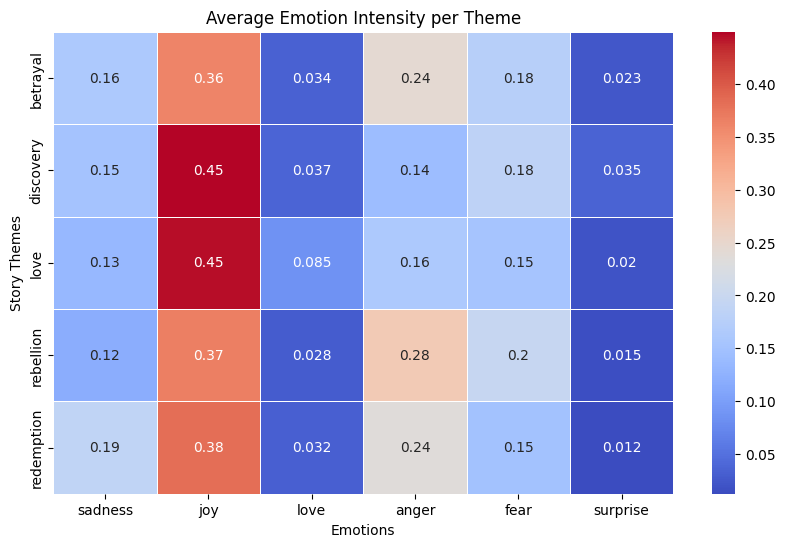

In [225]:
plt.figure(figsize=(10, 6))
sns.heatmap(theme_grouped, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Average Emotion Intensity per Theme")
plt.xlabel("Emotions")
plt.ylabel("Story Themes")
plt.show()


# Step 11: Print Summary

In [227]:
print("\n**Emotional Analysis of Themes**")
print(theme_grouped)


**Emotional Analysis of Themes**
             sadness       joy      love     anger      fear  surprise
theme                                                                 
betrayal    0.162268  0.361587  0.034448  0.243583  0.175356  0.022758
discovery   0.152373  0.449501  0.037097  0.141287  0.184681  0.035061
love        0.134968  0.445900  0.084963  0.161444  0.153111  0.019614
rebellion   0.118824  0.366774  0.027841  0.275827  0.196141  0.014594
redemption  0.188181  0.381479  0.032363  0.235472  0.150063  0.012442


In [242]:
print(df_emotions["theme"].unique())


['redemption' 'discovery' 'betrayal' 'love' 'rebellion']


In [244]:
df_emotions.head()

,index,story,theme,story_emotion_vector,sadness,joy,love,anger,fear,surprise
0,0,In a reality where pillars of fire had danced ...,redemption,"[0.5879056453704834, 0.2111320477561094, 0.047...",0.587906,0.211132,0.047633,0.101521,0.049543,0.002265
1,1,In an epoch characterized by towering peaks of...,discovery,"[0.18160645973875944, 0.6750672762063914, 0.01...",0.181606,0.675067,0.012012,0.060524,0.066685,0.004106
2,2,"In the midst of a quaint hamlet, nestled betwe...",discovery,"[0.018666005041450263, 0.6614795417757705, 0.0...",0.018666,0.661480,0.010948,0.084634,0.215141,0.009132
3,3,"In the heart of an isolated, provincial region...",betrayal,"[0.11796499322586254, 0.4481127232378212, 0.00...",0.117965,0.448113,0.006952,0.166713,0.199629,0.060628
4,4,"In the pulsating heart of a bustling, steel-cl...",redemption,"[0.05442076021184524, 0.49201023367802715, 0.0...",0.054421,0.492010,0.049288,0.373000,0.025664,0.005617


In [246]:
print(df_emotions[df_emotions["theme"] == "love"])


     index                                              story theme  \
5        5  He built worlds with his mind. His hands, tool...  love   
6        6  In a pocket of rural tranquility, a man arrive...  love   
11      11  In the aftermath of chaos, the cities lay empt...  love   
13      13  In an olden epoch, under the broad canvas of a...  love   
15      15  Beneath the cosmic tapestry where stars twinkl...  love   
..     ...                                                ...   ...   
566    566  In a bustling cityscape of glass and steel, wh...  love   
590    590  Among the cobblestone streets of an epoch long...  love   
592    592  There was chaos. Smoke curled. Buildings shatt...  love   
594    594  In a time long past, beneath the shadow of the...  love   
601    601  Amidst the wreckage that once was, he stood. H...  love   

                                  story_emotion_vector   sadness       joy  \
5    [0.14883859166988142, 0.4367512751660768, 0.05...  0.148839  0.4

In [250]:
print(story_emotion_df)

      sadness       joy      love     anger      fear  surprise
0    0.587906  0.211132  0.047633  0.101521  0.049543  0.002265
1    0.181606  0.675067  0.012012  0.060524  0.066685  0.004106
2    0.018666  0.661480  0.010948  0.084634  0.215141  0.009132
3    0.117965  0.448113  0.006952  0.166713  0.199629  0.060628
4    0.054421  0.492010  0.049288  0.373000  0.025664  0.005617
..        ...       ...       ...       ...       ...       ...
597  0.062162  0.615582  0.020913  0.193578  0.096202  0.011564
598  0.105740  0.140993  0.040049  0.489289  0.220940  0.002988
599  0.176744  0.196759  0.043235  0.229680  0.348640  0.004942
600  0.074178  0.582149  0.008888  0.271753  0.061103  0.001929
601  0.241232  0.420451  0.036683  0.153442  0.104162  0.044030

[602 rows x 6 columns]


In [252]:
data["stories"][5]

{'index': 5,
 'theme': 'love',
 'setting': 'outer space',
 'person': 'inventor',
 'style': 'concise',
 'outcome': 'defeat',
 'object_concept': 'suit',
 'story': 'He built worlds with his mind. His hands, tools of creation. No, not on solid ground. Beyond the blue veil. The universe was his raw material. \\n\\nYet, he craved more.\\n\\nA new project took root. A contraption to give birth to affection. A suit was devised. To be worn, to be lived in. Its function – to catalyst emotions. Unprecedented, unheard of. A mechanical heart, the suit had. Not of iron, but of emotions. Still, void of human touch.\\n\\nHer name, Iris. A woman of vigor. Of intellect. The planet’s leading linguist. A common friend united them. An evening. A gala. \\n\\nShe saw him. A spark arose. His eyes met hers. Hesitant, yet longing. Conversation unfolded. About the cosmos. About his creations. About her linguistic prowess. Drawn, they were, to one another.\\n\\nThe suit was ready. He chose Iris. His first test su

In [256]:
print(df_emotions[df_emotions["theme"] == "betrayal"]["story"].head(5))


3     In the heart of an isolated, provincial region...
7     Protagonist One, a media professional, found h...
9     In the palpable, humming milieu of an era ador...
12    In a city of glass towers and neon lights, liv...
16    In the heart of a quaint village visitors ofte...
Name: story, dtype: object
